In [1]:
import os,cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import h5

from keras import backend as K
K.set_image_data_format("channels_last")

from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation
from keras.optimizers import SGD,RMSprop,Adam,Nadam

#from keras.callbacks import ModelCheckpoint as MCP ,EarlyStopping as ESP, ReduceLROnPlateau as RLP
from tensorflow.keras.callbacks import ModelCheckpoint as MCP ,EarlyStopping as ESP, ReduceLROnPlateau as RLP

In [2]:
path=r'C:\Users\saura\callback_saurabh'

directories = os.listdir(path)
directories

['JEANS', 'TROUSER']

In [3]:

#Resize the all the images to a standard size of 128*128
im_hg=128
im_wg=128
channel=1 #as all my images are grey scale

In [4]:
#creating a list to store the images extracted         
imgs=[]
for ds in directories:
    img_list=os.listdir(path+'/'+ ds)
    print ('Extracting images from',(ds))
    
    for i in img_list:
        input_img=cv2.imread(path + '/'+ ds + '/'+ i )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        img_resize=cv2.resize(input_img,(128,128))
        imgs.append(img_resize)
           
img_data = np.array(imgs).astype('float32')
img_data =img_data/255 #normalization

print (img_data.shape)



Extracting images from JEANS
Extracting images from TROUSER
(1200, 128, 128)


In [5]:
#checking channel configuration
if channel==1:
    if K.image_data_format()==("channels_first"):
    
        img_data= np.expand_dims(img_data, axis=1) 
        print("Theano ordering has been used /n")
        print (img_data.shape)
    else:
        img_data= np.expand_dims(img_data, axis=3) 
        print("Tensorflow ordering has been used")
        print (img_data.shape)
else:
    if K.image_data_format()==("channels_first"):
        img_data=np.rollaxis(img_data,3,1)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)


Tensorflow ordering has been used
(1200, 128, 128, 1)


In [6]:
classes=2
class_name=["JEANS","TROUSER"]
sample_length=img_data.shape[0]

labels = np.ones((sample_length,),dtype="int64") #it'll create a matrix of 1*1

#assigning values, we know that we have 600 images in each folder so assigning values according to them

labels[0:600]=0
labels[600:1200]=1


In [7]:
#using one_hot encoding
Y=np_utils.to_categorical(labels,classes)

In [8]:
#using shuffle and train_test_split methods of sklearn for shuffling and splitting the dataset
x,y = shuffle(img_data,Y, random_state=4)

# Splitting the dataset in 80_20 ratio 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
#splitting the dataset into 80:20 will give 1440 images for training and 360 for testing

In [9]:
print("Shape of x_train:\t",x_train.shape)
print("\nShape of x_test:\t",x_test.shape)
print("\nShape of y_train:\t",y_train.shape)
print("\nShape of y_test:\t",y_test.shape)


Shape of x_train:	 (960, 128, 128, 1)

Shape of x_test:	 (240, 128, 128, 1)

Shape of y_train:	 (960, 2)

Shape of y_test:	 (240, 2)


In [10]:
ip_shape=img_data[0].shape
ip_shape
#here we have single channel images of 128*128 resolution


(128, 128, 1)

In [11]:
#BUILDING THE LAYOUT OF CNN MODEL

m=Sequential(name="SCRAPPED_IMAGE_DATASET")
m.add(Conv2D(32,(3,3),name="Conv_1",activation="relu",kernel_initializer='he_uniform',padding='same',input_shape=ip_shape))
m.add(MaxPooling2D(pool_size = (2,2)))

m.add(Conv2D(64,(3,3),name="Conv_2",activation="relu",kernel_initializer='he_uniform',padding='same'))
m.add(MaxPooling2D(pool_size = (2,2)))      
m.add(Dropout(0.5))
      
m.add(Conv2D(64, (3, 3), activation='relu',name="Conv_3" ,kernel_initializer='he_uniform', padding='same'))
m.add(MaxPooling2D((2, 2)))


m.add(Flatten())
      
m.add(Dense(64, activation='relu', kernel_initializer='he_uniform',name="HIDDEN_1"))
m.add(Dense(128, activation='relu', kernel_initializer='he_uniform',name="HIDDEN_2"))    
m.add(Dropout(0.5))
m.add(Dense(2, activation='softmax',name="OUTPUT"))
print("\nSummary:",m.summary())


Model: "SCRAPPED_IMAGE_DATASET"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 

In [12]:
#checking model configuration
m.get_config()

{'name': 'SCRAPPED_IMAGE_DATASET',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'Conv_1',
    'trainable': True,
    'batch_input_shape': (None, 128, 128, 1),
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 2.0,
      'mode': 'fan_in',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d',
    'trainable': True,
    'dtype': 'float32',
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format'

# compiling the model with SGD as optimizer with momentum & callbacks

AT LEARNING RATE 0.001
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.1771 - accuracy: 0.5139
Epoch 00001: val_loss improved from inf to 0.69323, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.001.h5
48/48 [==============================] - 22s 462ms/step - loss: 1.1771 - accuracy: 0.5139 - val_loss: 0.6932 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.5317
Epoch 00002: val_loss improved from 0.69323 to 0.69217, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.001.h5
48/48 [==============================] - 19s 403ms/step - loss: 0.6959 - accuracy: 0.5317 - val_loss: 0.6922 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.5822
Epoch 00003: val_loss improved from 0.69217 to 0.68174, saving model to C:\Users\saura\optimizers\s

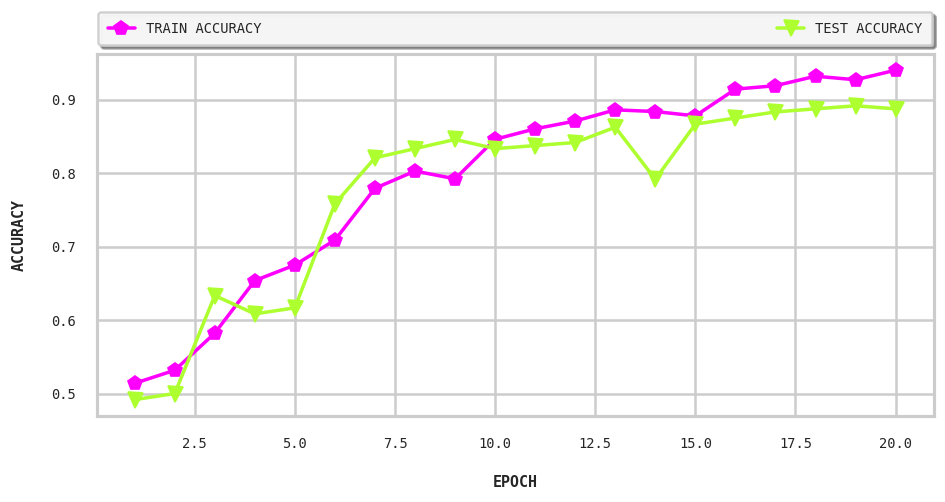


LOSS VALUES


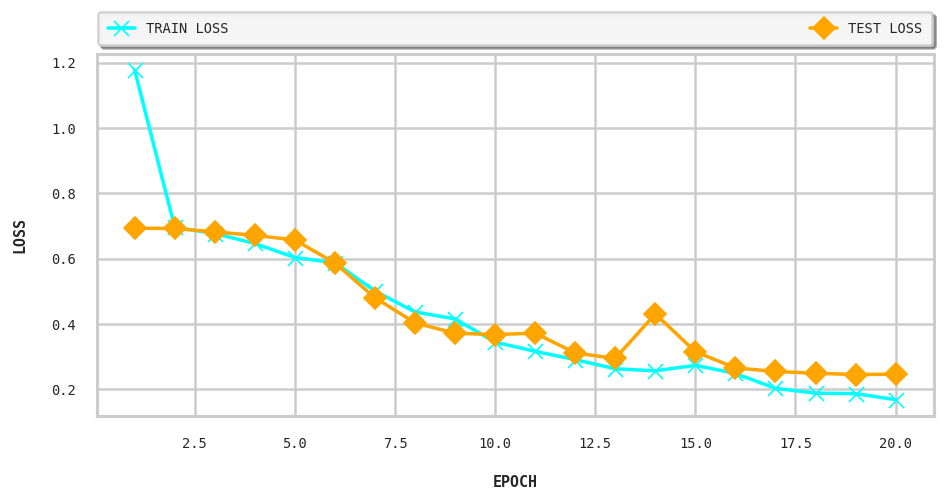


AT LEARNING RATE 0.01
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.7185 - accuracy: 0.5845
Epoch 00001: val_loss improved from inf to 0.68290, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.01.h5
48/48 [==============================] - 20s 419ms/step - loss: 0.7185 - accuracy: 0.5845 - val_loss: 0.6829 - val_accuracy: 0.5375 - lr: 0.0100
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.6315
Epoch 00002: val_loss improved from 0.68290 to 0.62198, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.01.h5
48/48 [==============================] - 19s 389ms/step - loss: 0.6545 - accuracy: 0.6315 - val_loss: 0.6220 - val_accuracy: 0.7208 - lr: 0.0100
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.6984
Epoch 00003: val_loss improved from 0.62198 to 0.61057, saving model to C:\Users\saura\optimizers\sau

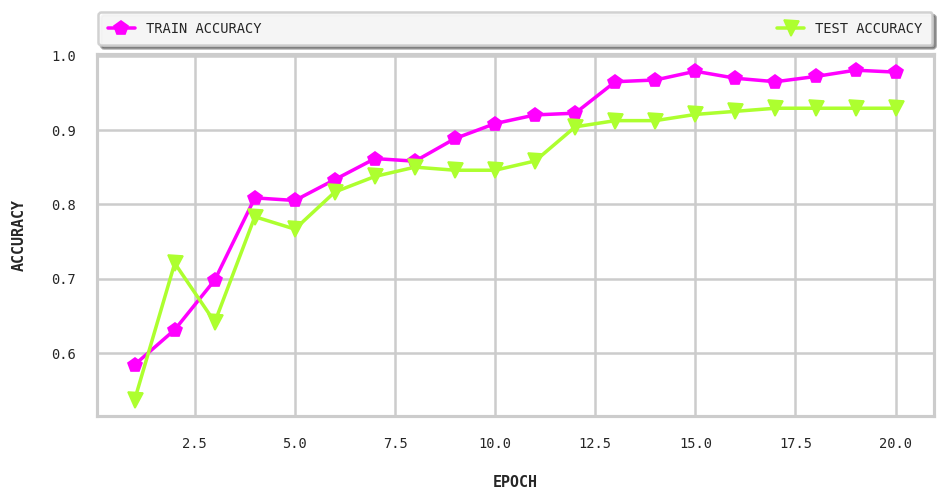


LOSS VALUES


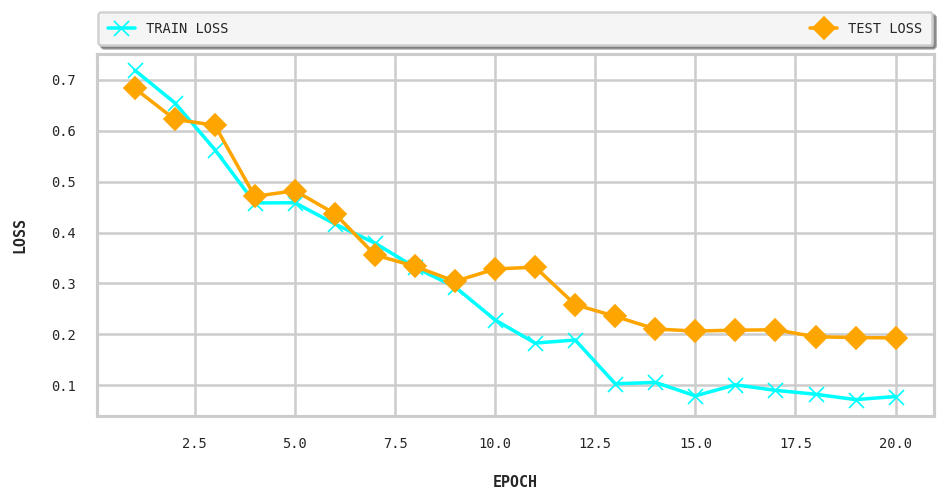


AT LEARNING RATE 0.025
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.8125
Epoch 00001: val_loss improved from inf to 0.49314, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.025.h5
48/48 [==============================] - 19s 391ms/step - loss: 0.4598 - accuracy: 0.8125 - val_loss: 0.4931 - val_accuracy: 0.8083 - lr: 0.0250
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8063
Epoch 00002: val_loss improved from 0.49314 to 0.41986, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.025.h5
48/48 [==============================] - 19s 390ms/step - loss: 0.4741 - accuracy: 0.8063 - val_loss: 0.4199 - val_accuracy: 0.8125 - lr: 0.0250
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8498
Epoch 00003: val_loss improved from 0.41986 to 0.39917, saving model to C:\Users\saura\optimizers\

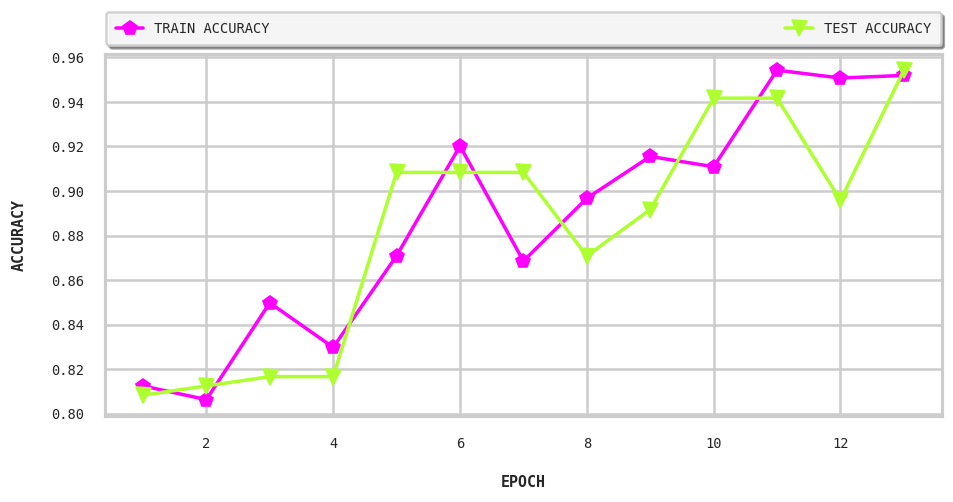


LOSS VALUES


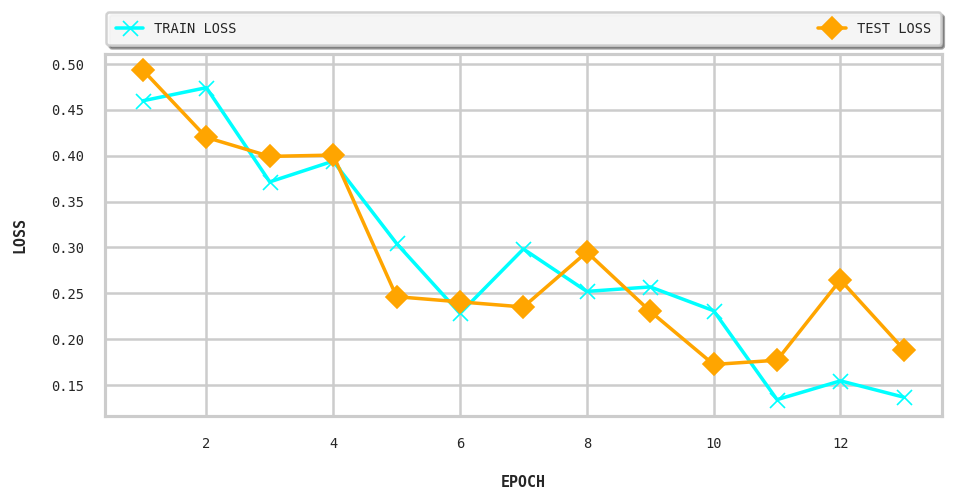

In [13]:
lr=(0.001,0.01,0.025)
for i in (lr):
    print("AT LEARNING RATE",i)
    print("__"*15)
    print()     
    opt = SGD(learning_rate=i, momentum=0.9,nesterov=False)
    m.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    
 #defining the callbacks   
    check= MCP(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt"+str(i)+".h5",
               monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='min')

    early=ESP(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min',baseline=None, restore_best_weights=True)
    rlp=RLP(monitor='val_loss',factor=0.1, patience=2, verbose=1, mode='min',min_delta=0)
    cb=[early,check,rlp]
    
#training the dataset
    sgd_momt = m.fit(x_train,y_train,batch_size =18,epochs=20,steps_per_epoch=np.floor(len(x_train)//20),
                     validation_data = (x_test, y_test),callbacks=cb)

#predicting the results for test dataset
    print("\npredicting the model performance wrt test dataset")
    prediction= m.evaluate(x_test, y_test)
    prediction 
    print("\nPrediction_TEST LOSS:\t",prediction[0]*100)
    print("\nPrediction_TEST ACCURACY:\t",prediction[1]*100)
    print()
    
    
    
#visualization
   
    record= sgd_momt.history
    loss=record['loss']
    acc=record['accuracy']
    valid_loss=record['val_loss']
    val_acu=record['val_accuracy']
    epoch=range(1,len(loss)+1)
    
    #PLOTTING ACCURACY VALUES
    print('Accuracy Value')
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,acc,label="TRAIN ACCURACY")
    l2=plt.plot(epoch,val_acu,label="TEST ACCURACY")

    plt.setp(l1,color='fuchsia',marker="p",linewidth=2.1)
    plt.setp(l2,color='greenyellow',marker="v",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('ACCURACY\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    
#PLOTTING LOSS VALUES
    print("\nLOSS VALUES")
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,loss,label="TRAIN LOSS")
    l2=plt.plot(epoch,valid_loss,label="TEST LOSS")

    plt.setp(l1,color='aqua',marker="x",linewidth=2.1)
    plt.setp(l2,color='orange',marker="D",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('LOSS\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    print()


###### compiling the model with SGD with momentum and nestrov with callbacks

AT LEARNING RATE 0.001
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9468
Epoch 00001: val_loss improved from inf to 0.16375, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.001.h5
48/48 [==============================] - 19s 389ms/step - loss: 0.1433 - accuracy: 0.9468 - val_loss: 0.1637 - val_accuracy: 0.9458 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9636
Epoch 00002: val_loss improved from 0.16375 to 0.15781, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.001.h5
48/48 [==============================] - 18s 383ms/step - loss: 0.1142 - accuracy: 0.9636 - val_loss: 0.1578 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9531
Epoch 00003: val_loss improved from 0.15781 to 0.15402, saving model to C:\

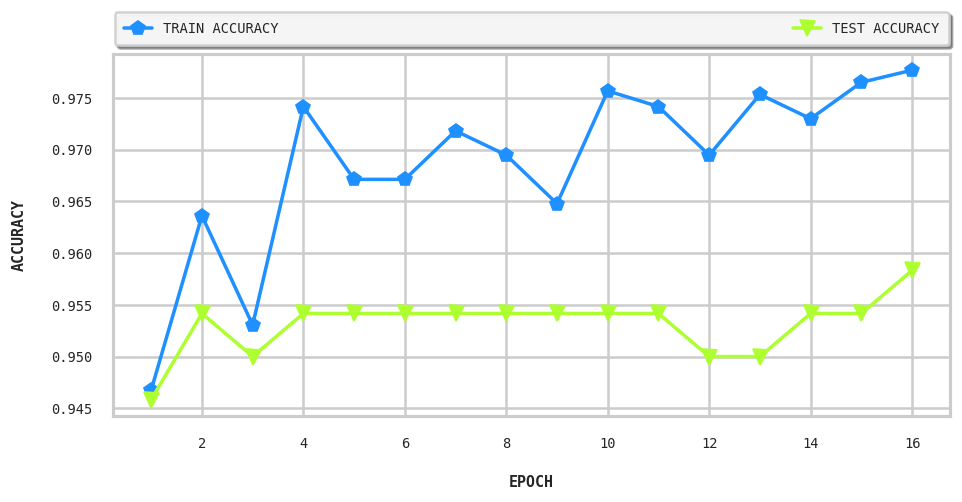


LOSS VALUES


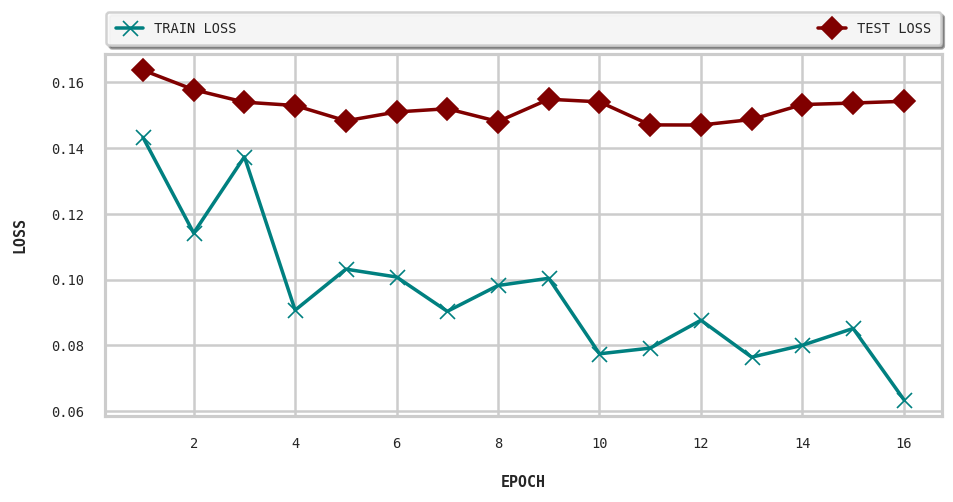


AT LEARNING RATE 0.01
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9711
Epoch 00001: val_loss improved from inf to 0.18542, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.01.h5
48/48 [==============================] - 19s 396ms/step - loss: 0.0922 - accuracy: 0.9711 - val_loss: 0.1854 - val_accuracy: 0.9500 - lr: 0.0100
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9765
Epoch 00002: val_loss did not improve from 0.18542
48/48 [==============================] - 18s 378ms/step - loss: 0.0573 - accuracy: 0.9765 - val_loss: 0.2134 - val_accuracy: 0.9375 - lr: 0.0100
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9707
Epoch 00003: val_loss improved from 0.18542 to 0.14988, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.01.h5
48/48 [===================

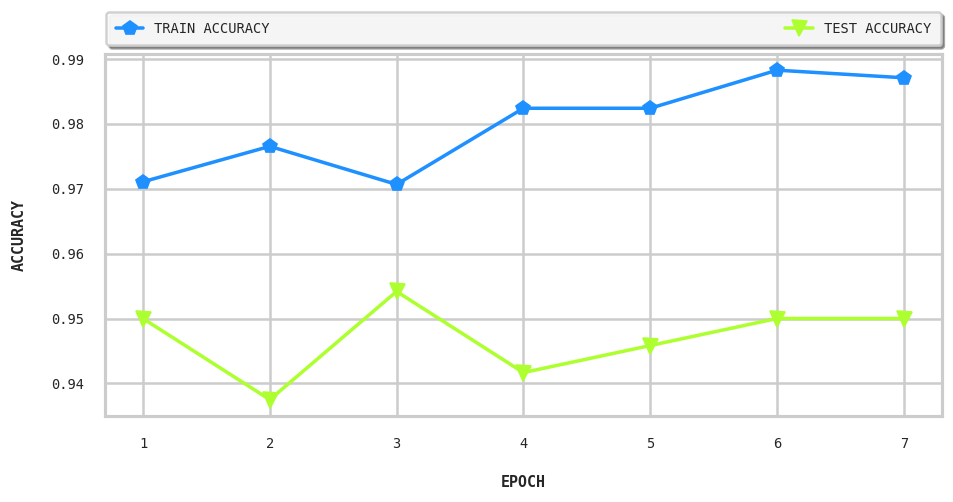


LOSS VALUES


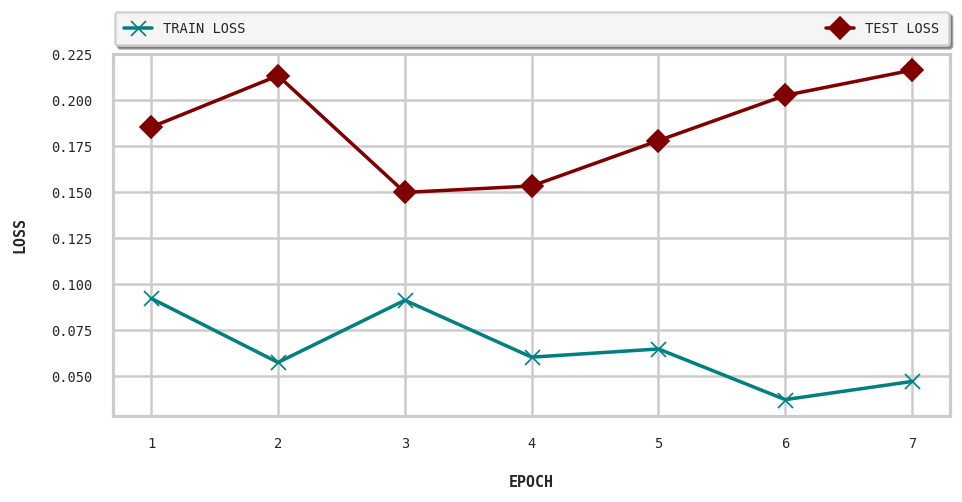


AT LEARNING RATE 0.025
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9410
Epoch 00001: val_loss improved from inf to 0.24683, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.025.h5
48/48 [==============================] - 19s 390ms/step - loss: 0.1794 - accuracy: 0.9410 - val_loss: 0.2468 - val_accuracy: 0.8958 - lr: 0.0250
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9437
Epoch 00002: val_loss improved from 0.24683 to 0.17986, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.025.h5
48/48 [==============================] - 18s 380ms/step - loss: 0.1457 - accuracy: 0.9437 - val_loss: 0.1799 - val_accuracy: 0.9167 - lr: 0.0250
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9683
Epoch 00003: val_loss did not improve from 0.17986
48/48 [================

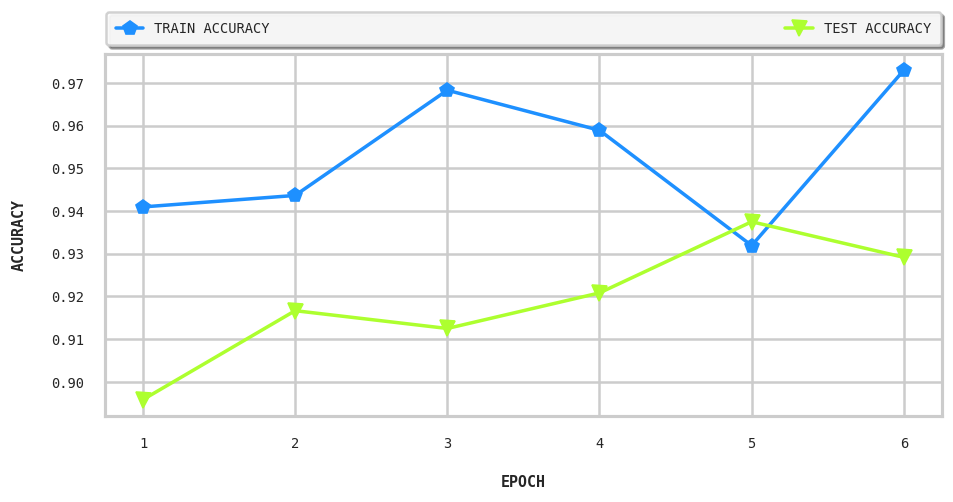


LOSS VALUES


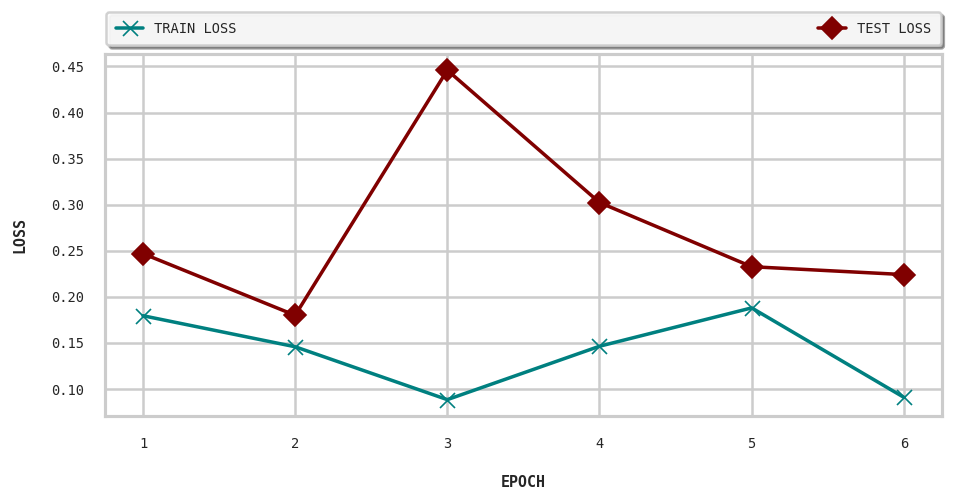

In [14]:
lr=(0.001,0.01,0.025)
for i in (lr):
    print("AT LEARNING RATE",i)
    print("__"*15)
    print()     
    opt = SGD(learning_rate=i, momentum=0.9,nesterov=True)
    m.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    
#defining the callbacks    
    check= MCP(r"C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov"+str(i)+".h5",
          monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='min')

    early=ESP(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min',baseline=None, restore_best_weights=True)

    rlp=RLP(monitor='val_loss',factor=0.1, patience=3, verbose=1, mode='min',min_delta=0)


    cb=[early,check,rlp]
    
#training the dataset
    sgd_momt_nest = m.fit(x_train,y_train,batch_size =18,epochs=20,steps_per_epoch=np.floor(len(x_train)//20),
                     validation_data = (x_test, y_test),callbacks=cb)

#predicting the results for test dataset
    print("\npredicting the model performance wrt test dataset")
    prediction= m.evaluate(x_test, y_test)
    prediction 
    print("\nPrediction_TEST LOSS:\t",prediction[0]*100)
    print("\nPrediction_TEST ACCURACY:\t",prediction[1]*100)
    print()
    
    #visualization
   
       
    
#visualization
   
    record= sgd_momt_nest.history
    loss=record['loss']
    acc=record['accuracy']
    valid_loss=record['val_loss']
    val_acu=record['val_accuracy']
    epoch=range(1,len(loss)+1)
    
    #PLOTTING ACCURACY VALUES
    print('Accuracy Value')
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,acc,label="TRAIN ACCURACY")
    l2=plt.plot(epoch,val_acu,label="TEST ACCURACY")

    plt.setp(l1,color='dodgerblue',marker="p",linewidth=2.1)
    plt.setp(l2,color='greenyellow',marker="v",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('ACCURACY\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    
#PLOTTING LOSS VALUES
    print("\nLOSS VALUES")
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,loss,label="TRAIN LOSS")
    l2=plt.plot(epoch,valid_loss,label="TEST LOSS")

    plt.setp(l1,color='teal',marker="x",linewidth=2.1)
    plt.setp(l2,color='maroon',marker="D",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('LOSS\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    print()

# compiling the model with RMSPROP with callbacks



AT LEARNING RATE 0.001
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9664
Epoch 00001: val_loss improved from inf to 0.18760, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_RMSPROP0.001.h5
48/48 [==============================] - 19s 400ms/step - loss: 0.1316 - accuracy: 0.9664 - val_loss: 0.1876 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9812
Epoch 00002: val_loss did not improve from 0.18760
48/48 [==============================] - 18s 380ms/step - loss: 0.0495 - accuracy: 0.9812 - val_loss: 0.2625 - val_accuracy: 0.9458 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9871
Epoch 00003: val_loss did not improve from 0.18760
48/48 [==============================] - 18s 380ms/step - loss: 0.0483 - accuracy: 0.9871 - val_loss: 0.1976 - val_accuracy:

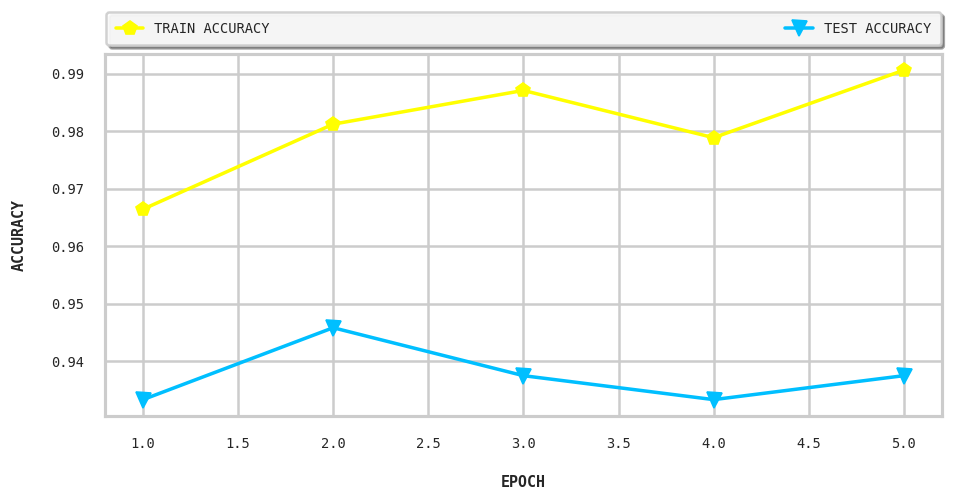


LOSS VALUES


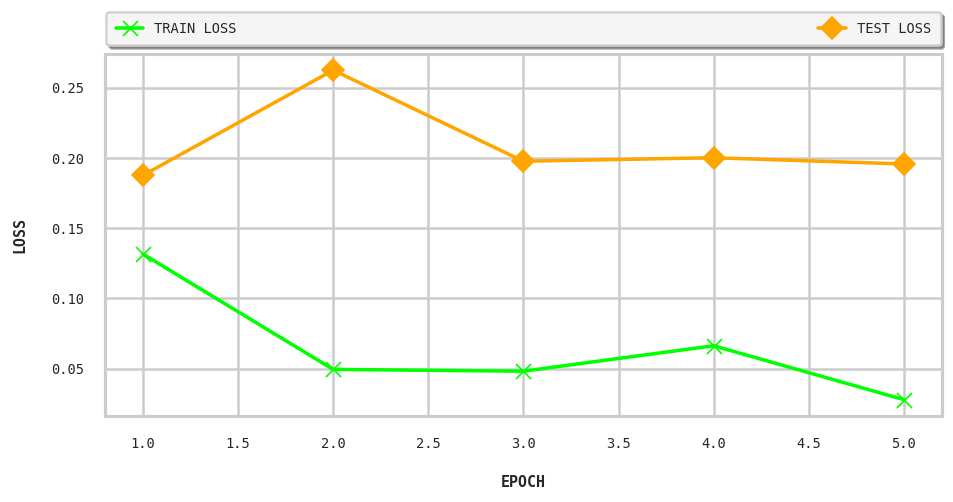


AT LEARNING RATE 0.01
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 5.0326 - accuracy: 0.7882
Epoch 00001: val_loss improved from inf to 0.62032, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_RMSPROP0.01.h5
48/48 [==============================] - 19s 390ms/step - loss: 5.0326 - accuracy: 0.7882 - val_loss: 0.6203 - val_accuracy: 0.6958 - lr: 0.0100
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8568
Epoch 00002: val_loss did not improve from 0.62032
48/48 [==============================] - 18s 382ms/step - loss: 0.3969 - accuracy: 0.8568 - val_loss: 0.8483 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.8967
Epoch 00003: val_loss improved from 0.62032 to 0.57521, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_RMSPROP0.01.h5
48/48 [===================

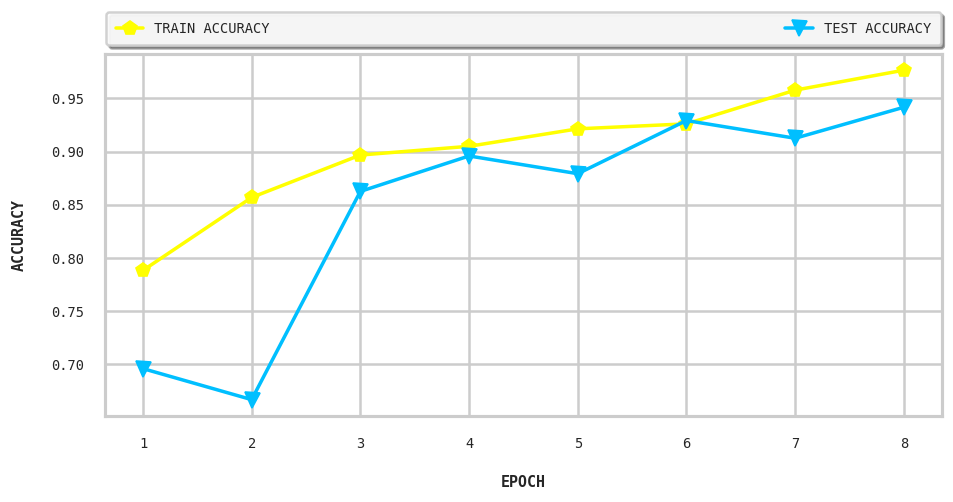


LOSS VALUES


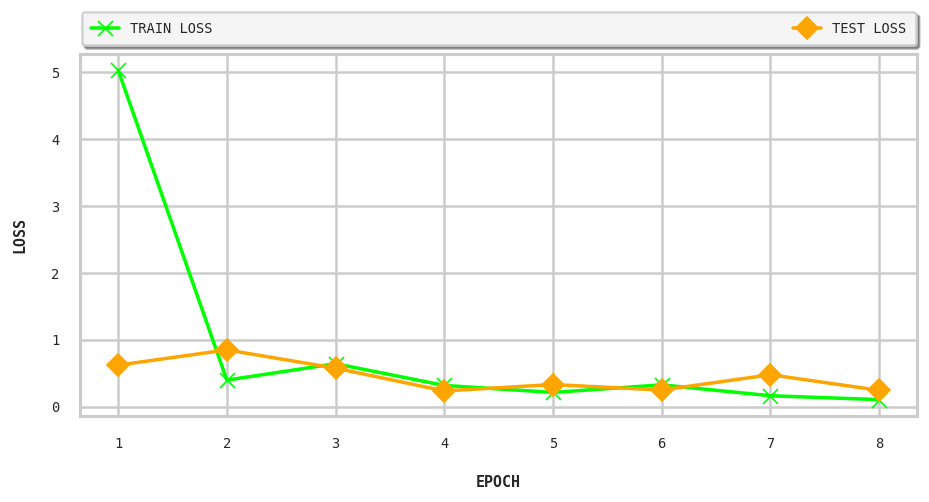


AT LEARNING RATE 0.025
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 35.5929 - accuracy: 0.6053
Epoch 00001: val_loss improved from inf to 0.66402, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_RMSPROP0.025.h5
48/48 [==============================] - 19s 390ms/step - loss: 35.5929 - accuracy: 0.6053 - val_loss: 0.6640 - val_accuracy: 0.6125 - lr: 0.0250
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 1.8997 - accuracy: 0.6232
Epoch 00002: val_loss improved from 0.66402 to 0.59048, saving model to C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_RMSPROP0.025.h5
48/48 [==============================] - 19s 396ms/step - loss: 1.8997 - accuracy: 0.6232 - val_loss: 0.5905 - val_accuracy: 0.6875 - lr: 0.0250
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 1.8699 - accuracy: 0.6620
Epoch 00003: val_loss did not improve from 0.59048
48/48 [==============

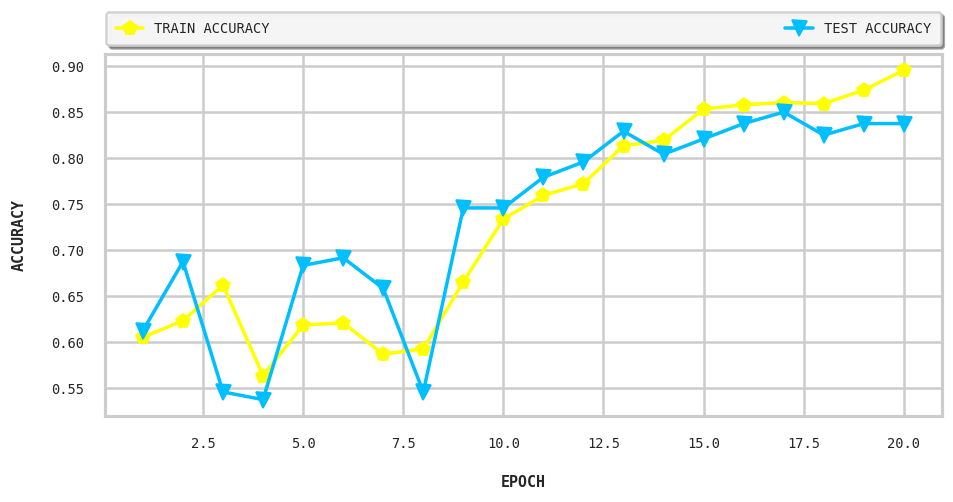


LOSS VALUES


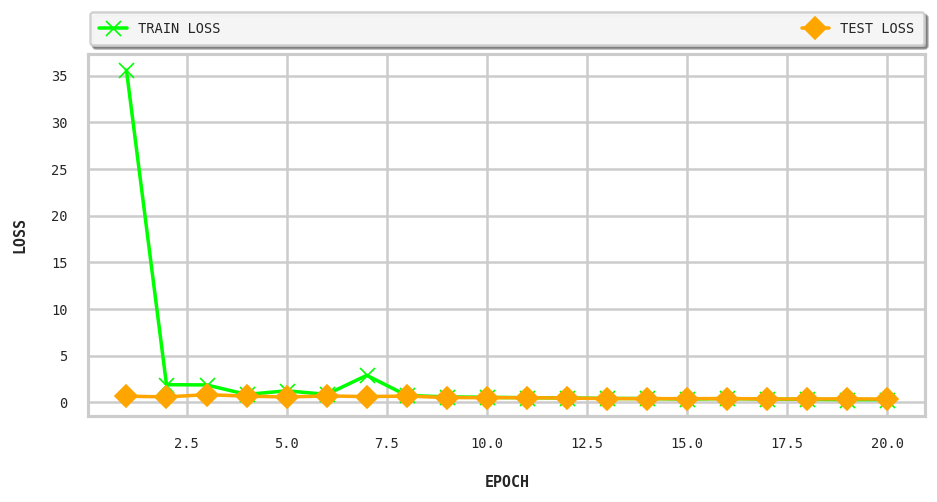

In [15]:
lr=(0.001,0.01,0.025)
for i in (lr):
    print("AT LEARNING RATE",i)
    print("__"*15)
    print()     
    opt = RMSprop(learning_rate=i)
    m.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    
#defining the callbacks    
    check= MCP(r"C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_RMSPROP"+str(i)+".h5",
          monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=True, mode='min')

    early=ESP(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min',baseline=None, restore_best_weights=True)

    rlp=RLP(monitor='val_loss',factor=0.1, patience=3, verbose=1, mode='min',min_delta=0)


    cb=[early,check,rlp]
    
#training the dataset
    rmsprp = m.fit(x_train,y_train,batch_size =18,epochs=20,steps_per_epoch=np.floor(len(x_train)//20),
                     validation_data = (x_test, y_test),callbacks=cb)

#predicting the results for test dataset
    print("\npredicting the model performance wrt test dataset")
    prediction= m.evaluate(x_test, y_test)
    prediction 
    print("\nPrediction_TEST LOSS:\t",prediction[0]*100)
    print("\nPrediction_TEST ACCURACY:\t",prediction[1]*100)
    print()
   
    
#visualization
   
    record= rmsprp.history
    loss=record['loss']
    acc=record['accuracy']
    valid_loss=record['val_loss']
    val_acu=record['val_accuracy']
    epoch=range(1,len(loss)+1)
    
    #PLOTTING ACCURACY VALUES
    print('Accuracy Value')
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,acc,label="TRAIN ACCURACY")
    l2=plt.plot(epoch,val_acu,label="TEST ACCURACY")

    plt.setp(l1,color='yellow',marker="p",linewidth=2.1)
    plt.setp(l2,color='deepskyblue',marker="v",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('ACCURACY\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    
#PLOTTING LOSS VALUES
    print("\nLOSS VALUES")
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,loss,label="TRAIN LOSS")
    l2=plt.plot(epoch,valid_loss,label="TEST LOSS")

    plt.setp(l1,color='lime',marker="x",linewidth=2.1)
    plt.setp(l2,color='orange',marker="D",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('LOSS\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    print()


# compiling the model with ADAM with callbacks

AT LEARNING RATE 0.001
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.8831
Epoch 00001: val_loss improved from inf to 0.36189, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.001.h5
48/48 [==============================] - 18s 384ms/step - loss: 0.2865 - accuracy: 0.8831 - val_loss: 0.3619 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.8920
Epoch 00002: val_loss improved from 0.36189 to 0.34592, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.001.h5
48/48 [==============================] - 20s 415ms/step - loss: 0.2666 - accuracy: 0.8920 - val_loss: 0.3459 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.8908
Epoch 00003: val_loss improved from 0.34592 to 0.33170, saving model to C:\Users\saura\optimizers\s

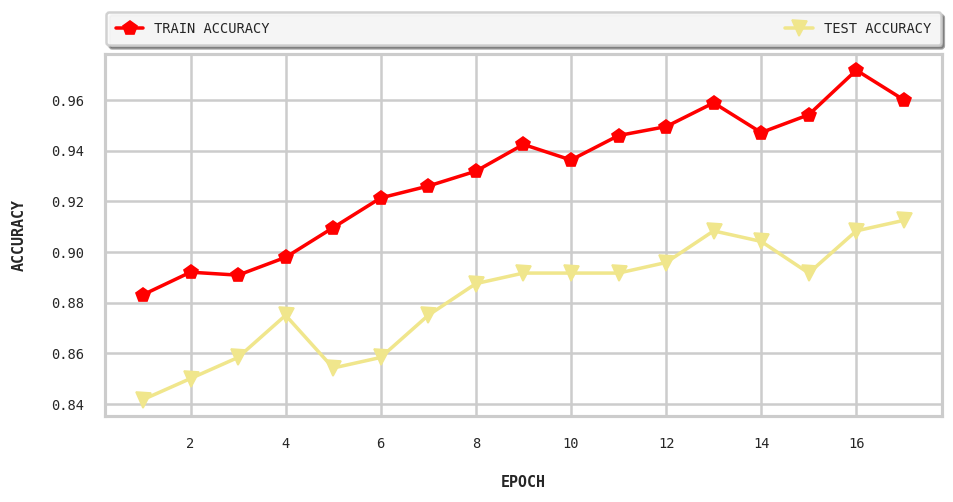


LOSS VALUES


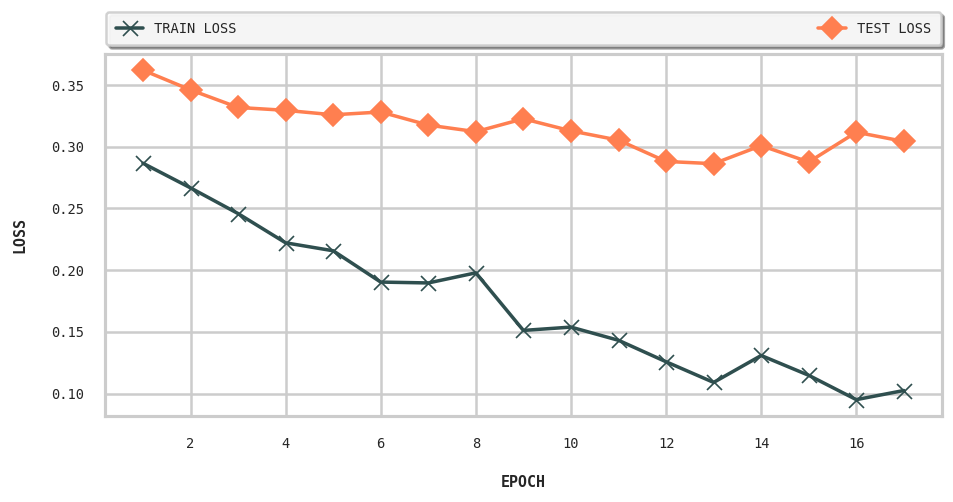


AT LEARNING RATE 0.01
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.8796
Epoch 00001: val_loss improved from inf to 0.33391, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.01.h5
48/48 [==============================] - 19s 387ms/step - loss: 0.5272 - accuracy: 0.8796 - val_loss: 0.3339 - val_accuracy: 0.8375 - lr: 0.0100
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.8944
Epoch 00002: val_loss improved from 0.33391 to 0.32895, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.01.h5
48/48 [==============================] - 18s 380ms/step - loss: 0.3140 - accuracy: 0.8944 - val_loss: 0.3290 - val_accuracy: 0.8458 - lr: 0.0100
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.8838
Epoch 00003: val_loss did not improve from 0.32895
48/48 [==============================] - 18s 373ms

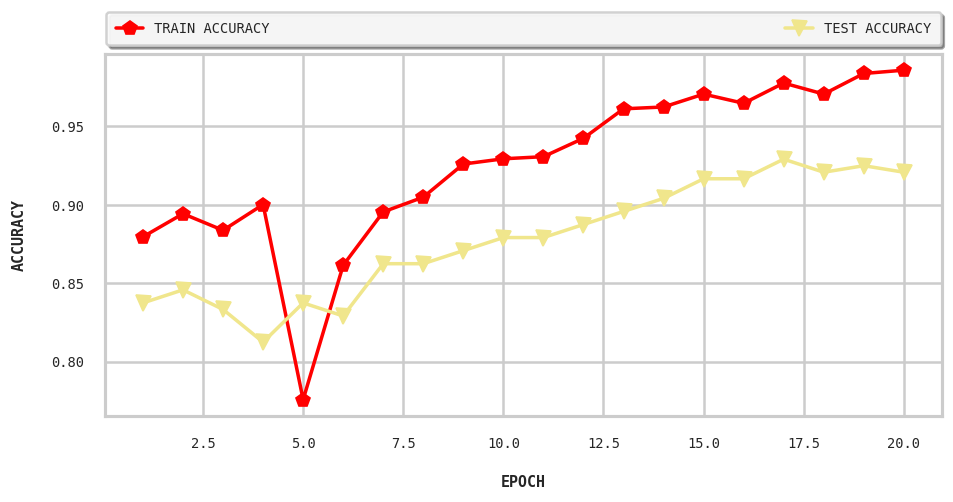


LOSS VALUES


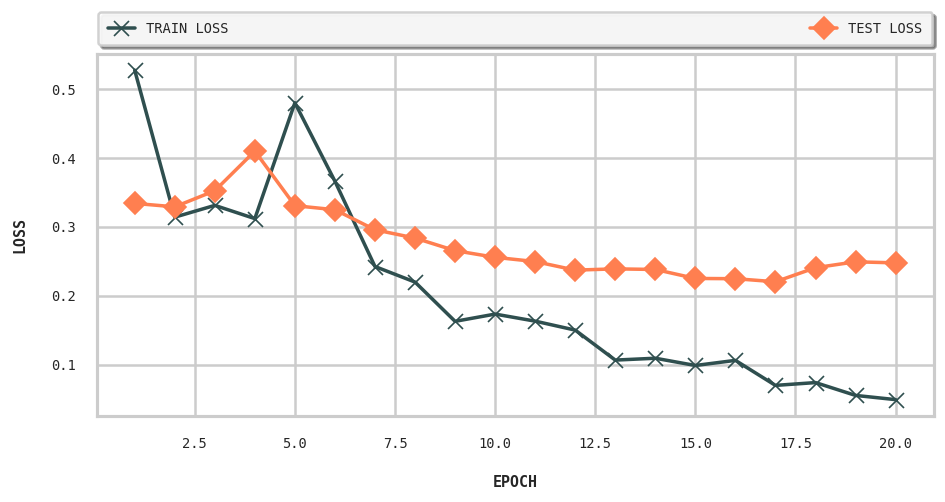


AT LEARNING RATE 0.025
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.6794
Epoch 00001: val_loss improved from inf to 0.72072, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.025.h5
48/48 [==============================] - 18s 385ms/step - loss: 0.7093 - accuracy: 0.6794 - val_loss: 0.7207 - val_accuracy: 0.5167 - lr: 0.0250
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5822
Epoch 00002: val_loss improved from 0.72072 to 0.61684, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.025.h5
48/48 [==============================] - 18s 378ms/step - loss: 0.6928 - accuracy: 0.5822 - val_loss: 0.6168 - val_accuracy: 0.6250 - lr: 0.0250
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5951
Epoch 00003: val_loss did not improve from 0.61684
48/48 [==============================] - 18s 37

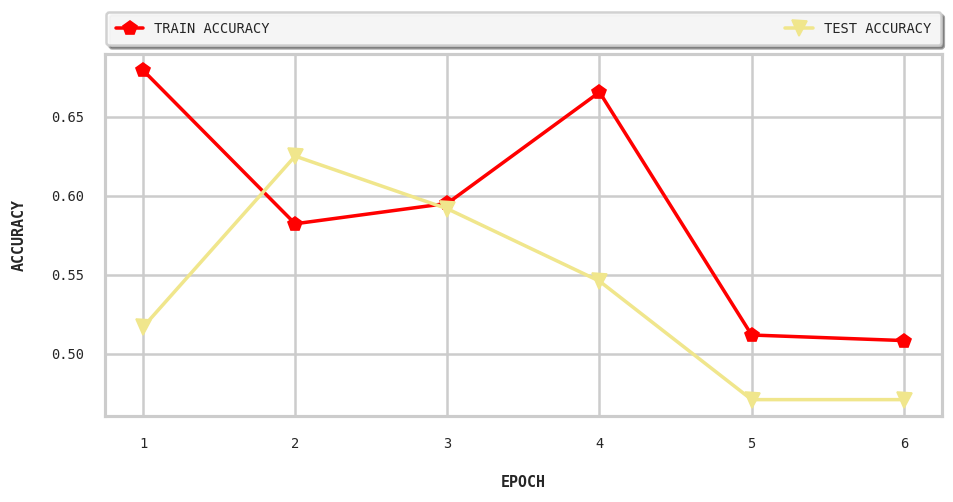


LOSS VALUES


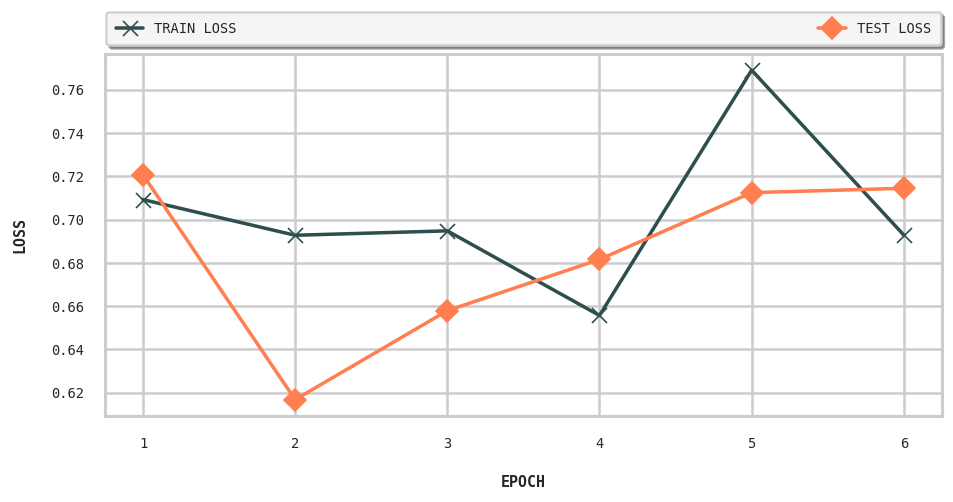

In [16]:
lr=(0.001,0.01,0.025)
for i in (lr):
    print("AT LEARNING RATE",i)
    print("__"*15)
    print()     
    opt = Adam(learning_rate=i)
    m.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    
#defining the callbacks    
    check= MCP(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM"+str(i)+".h5",
          monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='min')

    early=ESP(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min',baseline=None, restore_best_weights=True)

    rlp=RLP(monitor='val_loss',factor=0.1, patience=3, verbose=1, mode='min',min_delta=0)


    cb=[early,check,rlp]
    
#training the dataset
    adam = m.fit(x_train,y_train,batch_size =18,epochs=20,steps_per_epoch=np.floor(len(x_train)//20),
                     validation_data = (x_test, y_test),callbacks=cb)

#predicting the results for test dataset
    print("\npredicting the model performance wrt test dataset")
    prediction= m.evaluate(x_test, y_test)
    prediction 
    print("\nPrediction_TEST LOSS:\t",prediction[0]*100)
    print("\nPrediction_TEST ACCURACY:\t",prediction[1]*100)
    print()
       
    
#visualization
   
    record= adam.history
    loss=record['loss']
    acc=record['accuracy']
    valid_loss=record['val_loss']
    val_acu=record['val_accuracy']
    epoch=range(1,len(loss)+1)
    
    #PLOTTING ACCURACY VALUES
    print('Accuracy Value')
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,acc,label="TRAIN ACCURACY")
    l2=plt.plot(epoch,val_acu,label="TEST ACCURACY")

    plt.setp(l1,color='red',marker="p",linewidth=2.1)
    plt.setp(l2,color='khaki',marker="v",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('ACCURACY\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    
#PLOTTING LOSS VALUES
    print("\nLOSS VALUES")
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,loss,label="TRAIN LOSS")
    l2=plt.plot(epoch,valid_loss,label="TEST LOSS")

    plt.setp(l1,color='darkslategrey',marker="x",linewidth=2.1)
    plt.setp(l2,color='coral',marker="D",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('LOSS\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    print()


# compiling the model with NADAM with callbacks

AT LEARNING RATE 0.001
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.6481
Epoch 00001: val_loss improved from inf to 0.61010, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_NADAM0.001.h5
48/48 [==============================] - 19s 393ms/step - loss: 0.6452 - accuracy: 0.6481 - val_loss: 0.6101 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.6631
Epoch 00002: val_loss improved from 0.61010 to 0.59748, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_NADAM0.001.h5
48/48 [==============================] - 19s 389ms/step - loss: 0.6108 - accuracy: 0.6631 - val_loss: 0.5975 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.7077
Epoch 00003: val_loss improved from 0.59748 to 0.57326, saving model to C:\Users\saura\optimizers

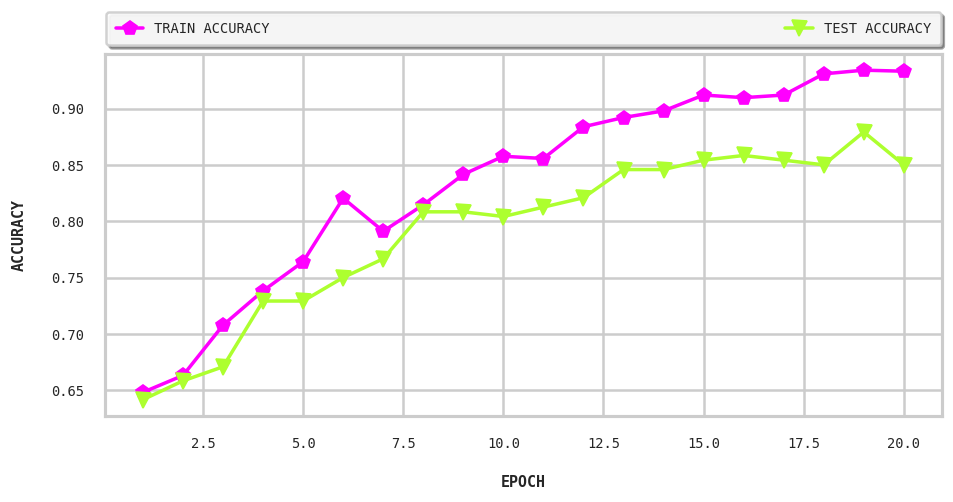


LOSS VALUES


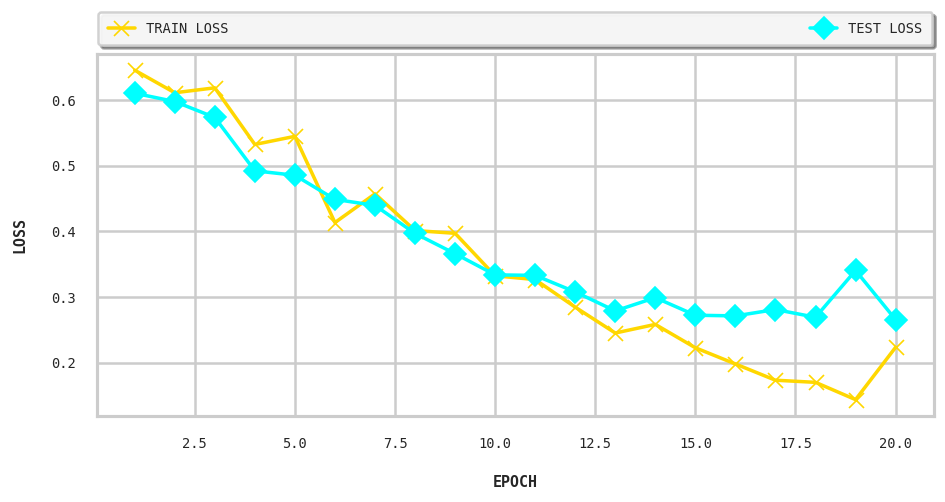


AT LEARNING RATE 0.01
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.9097
Epoch 00001: val_loss improved from inf to 0.35867, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_NADAM0.01.h5
48/48 [==============================] - 19s 397ms/step - loss: 0.3785 - accuracy: 0.9097 - val_loss: 0.3587 - val_accuracy: 0.8333 - lr: 0.0100
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.8697
Epoch 00002: val_loss improved from 0.35867 to 0.31549, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_NADAM0.01.h5
48/48 [==============================] - 19s 389ms/step - loss: 0.4488 - accuracy: 0.8697 - val_loss: 0.3155 - val_accuracy: 0.8417 - lr: 0.0100
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.8991
Epoch 00003: val_loss did not improve from 0.31549
48/48 [==============================] - 19s 389

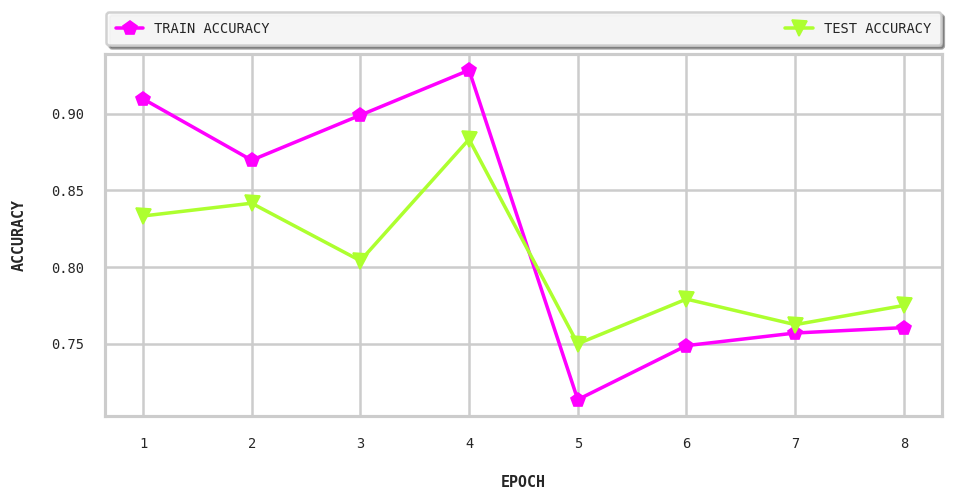


LOSS VALUES


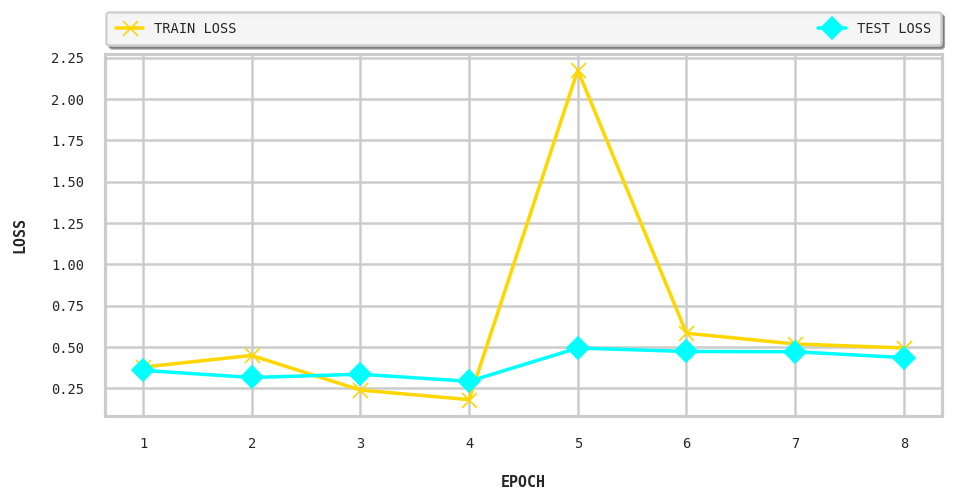


AT LEARNING RATE 0.025
______________________________

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.7929 - accuracy: 0.7234
Epoch 00001: val_loss improved from inf to 0.52411, saving model to C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_NADAM0.025.h5
48/48 [==============================] - 20s 418ms/step - loss: 0.7929 - accuracy: 0.7234 - val_loss: 0.5241 - val_accuracy: 0.6958 - lr: 0.0250
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.6937
Epoch 00002: val_loss did not improve from 0.52411
48/48 [==============================] - 19s 402ms/step - loss: 0.5945 - accuracy: 0.6937 - val_loss: 0.5785 - val_accuracy: 0.7083 - lr: 0.0250
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 3.6240 - accuracy: 0.5305
Epoch 00003: val_loss did not improve from 0.52411
48/48 [==============================] - 19s 387ms/step - loss: 3.6240 - accuracy: 0.5305 - val_loss: 0.6961 - val_accuracy: 0.4708 - 

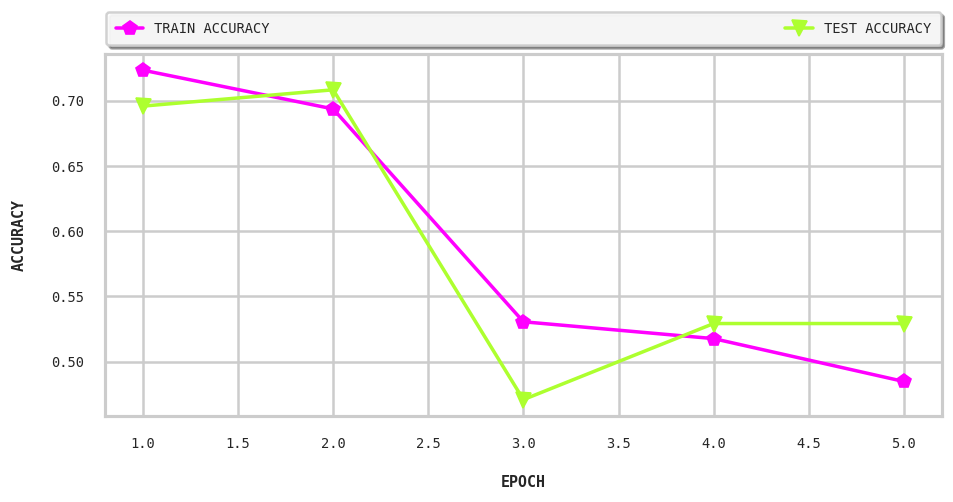


LOSS VALUES


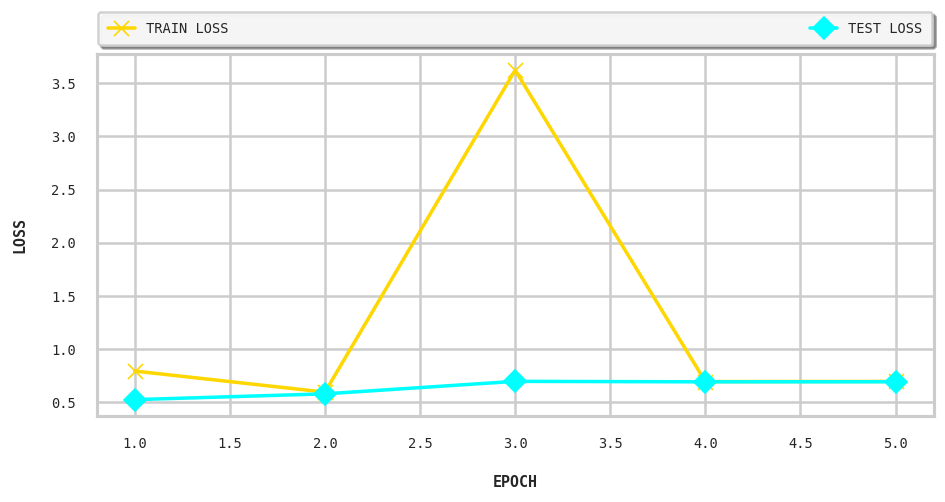

In [17]:
lr=(0.001,0.01,0.025)
for i in (lr):
    print("AT LEARNING RATE",i)
    print("__"*15)
    print()     
    opt = Nadam(learning_rate=i)
    m.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    
#defining the callbacks    
    check= MCP(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_NADAM"+str(i)+".h5",
          monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='min')

    early=ESP(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min',baseline=None, restore_best_weights=True)

    rlp=RLP(monitor='val_loss',factor=0.1, patience=3, verbose=1, mode='min',min_delta=0)


    cb=[early,check,rlp]
    
#training the dataset
    nadam = m.fit(x_train,y_train,batch_size =18,epochs=20,steps_per_epoch=np.floor(len(x_train)//20),
                     validation_data = (x_test, y_test),callbacks=cb)

#predicting the results for test dataset
    print("\npredicting the model performance wrt test dataset")
    prediction= m.evaluate(x_test, y_test)
    prediction 
    print("\nPrediction_TEST LOSS:\t",prediction[0]*100)
    print("\nPrediction_TEST ACCURACY:\t",prediction[1]*100)
    print()
    
    
    
   
    
#visualization
   
    record= nadam.history
    loss=record['loss']
    acc=record['accuracy']
    valid_loss=record['val_loss']
    val_acu=record['val_accuracy']
    epoch=range(1,len(loss)+1)
    
    #PLOTTING ACCURACY VALUES
    print('Accuracy Value')
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,acc,label="TRAIN ACCURACY")
    l2=plt.plot(epoch,val_acu,label="TEST ACCURACY")

    plt.setp(l1,color='fuchsia',marker="p",linewidth=2.1)
    plt.setp(l2,color='greenyellow',marker="v",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('ACCURACY\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    
#PLOTTING LOSS VALUES
    print("\nLOSS VALUES")
    plt.figure(figsize=(9,4),dpi=120)
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.5)
    l1=plt.plot(epoch,loss,label="TRAIN LOSS")
    l2=plt.plot(epoch,valid_loss,label="TEST LOSS")

    plt.setp(l1,color='gold',marker="x",linewidth=2.1)
    plt.setp(l2,color='cyan',marker="D",linewidth=2.1)

    plt.xlabel('\nEPOCH',weight='bold')
    plt.ylabel('LOSS\n',weight='bold')
    plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.1)
    
    plt.show()
    
    print()

# TESTING THE MODELS
loading SGD_MOMT model with 0.001 LR

In [18]:
from keras.models import load_model
from h5py import File

In [19]:
SGD_MO=load_model(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.001.h5")

In [20]:
testing = x_test[200:201]
print (testing.shape)


(1, 128, 128, 1)


In [21]:
print(SGD_MO.predict(testing))

[[0.29676658 0.70323336]]


In [22]:
np.argmax(SGD_MO.predict(testing), axis=-1)

array([1], dtype=int64)

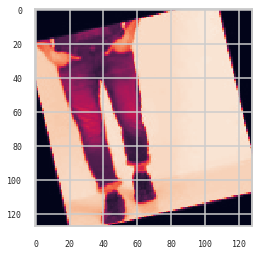

In [23]:
#the class zero belongs to saree, visualizing the image
im200th = testing.reshape((128,128))
plt.imshow(im200th)
plt.show()

Shape of test image (128, 128)


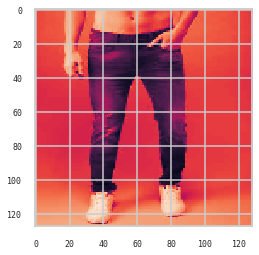

In [24]:
#doing prediction on an unseen image
test1 = cv2.imread(r"C:\Users\saura\saurabh\test_images\men_jeans\img_10.jpeg")
test1=cv2.cvtColor(test1, cv2.COLOR_BGR2GRAY)
test1=cv2.resize(test1,(128,128))
test1 = np.array(test1)
test1 = test1.astype('float32')
test1 =test1/255
print ("Shape of test image",test1.shape)

plt.imshow(test1)
plt.show()


In [25]:
#here the shape is (128,128) so iam defining the no of channel and sample so that it can be processed properly
if channel==1:
    if K.image_data_format()==("channels_first"):
        test_img= np.expand_dims(test1, axis=0)
        test_img= np.expand_dims(test1, axis=0)
        print (test_img.shape)
        print("\nTheano ordering has been used /n")
        print (test_img.shape)
    else:
        test_img= np.expand_dims(test1,axis=2) 
        test_img= np.expand_dims(test_img,axis=0)
        print("Tensorflow ordering has been used")
        print (test_img.shape)
else:
    if K.image_data_format()==("channels_first"):
        test_img=np.rollaxis(test1,2,0)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)
    else:
        test_img= np.expand_dims(test1, axis=0)
        print (test_image.shape)


Tensorflow ordering has been used
(1, 128, 128, 1)


In [26]:
#predicting the class
print(SGD_MO.predict(test_img))
print("CLASS:", SGD_MO.predict_classes(test_img))


[[0.9902598  0.00974015]]
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
CLASS: [0]


# loading SGD_MOMT model with 0.01 LR

In [27]:
SGD_MO=load_model(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.01.h5")

In [28]:
testing = x_test[100:101]
print (testing.shape)
print(SGD_MO.predict(testing))
np.argmax(SGD_MO.predict(testing), axis=-1)


(1, 128, 128, 1)
[[0.5659015 0.4340985]]


array([0], dtype=int64)

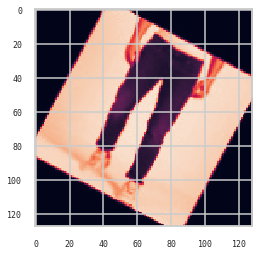

In [29]:
#the class 2 belongs to T_Shirt category, visualizing the image
im100th = testing.reshape((128,128))
plt.imshow(im100th)
plt.show()

Shape of test image (128, 128)


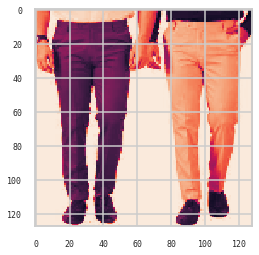

In [30]:
#doing prediction on an unseen image
test2 = cv2.imread(r"C:\Users\saura\saurabh\test_images\men_trouser\img_110.jpeg")
test2=cv2.cvtColor(test2, cv2.COLOR_BGR2GRAY)
test2=cv2.resize(test2,(128,128))
test2 = np.array(test2)
test2 = test2.astype('float32')
test2 =test2/255
print ("Shape of test image",test2.shape)

plt.imshow(test2)
plt.show()


In [31]:

#here the shape is (128,128) so iam defining the no of channel and sample so that it can be processed properly
if channel==1:
    if K.image_data_format()==("channels_first"):
        test_img= np.expand_dims(test2, axis=0)
        test_img= np.expand_dims(test2, axis=0)
        print (test_img.shape)
        print("\nTheano ordering has been used /n")
        print (test_img.shape)
    else:
        test_img= np.expand_dims(test2,axis=2) 
        test_img= np.expand_dims(test_img,axis=0)
        print("Tensorflow ordering has been used")
        print (test_img.shape)
else:
    if K.image_data_format()==("channels_first"):
        test_img=np.rollaxis(test2,2,0)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)
    else:
        test_img= np.expand_dims(test2, axis=0)
        print (test_image.shape)

Tensorflow ordering has been used
(1, 128, 128, 1)


In [32]:
#predicting the class
print(SGD_MO.predict(test_img))
print("CLASS:", SGD_MO.predict_classes(test_img))


[[8.045222e-09 1.000000e+00]]
CLASS: [1]


### loading SGD_MOMT model with 0.025 LR

In [33]:
SGD_MO=load_model(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_momt0.025.h5")

In [34]:
testing = x_test[10:11]
print (testing.shape)
print(SGD_MO.predict(testing))
np.argmax(SGD_MO.predict(testing), axis=-1)

(1, 128, 128, 1)
[[2.5305992e-05 9.9997473e-01]]


array([1], dtype=int64)

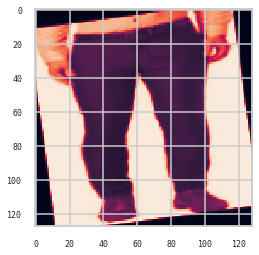

In [35]:
#the class 2 belongs to T_Shirt category, visualizing the image
im10th = testing.reshape((128,128))
plt.imshow(im10th)
plt.show()

Shape of test image (128, 128)


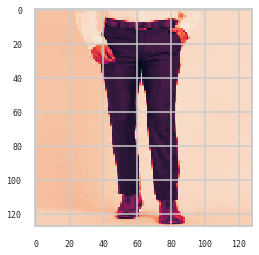

In [36]:
#doing prediction on an unseen image
test3 = cv2.imread(r"C:\Users\saura\saurabh\test_images\men_trouser\img_125.jpeg")
test3=cv2.cvtColor(test3, cv2.COLOR_BGR2GRAY)
test3=cv2.resize(test3,(128,128))
test3 = np.array(test3)
test3 = test3.astype('float32')
test3 =test3/255
print ("Shape of test image",test3.shape)

plt.imshow(test3)
plt.show()


In [37]:
#here the shape is (128,128) so iam defining the no of channel and sample so that it can be processed properly
if channel==1:
    if K.image_data_format()==("channels_first"):
        test_img= np.expand_dims(test3, axis=0)
        test_img= np.expand_dims(test3, axis=0)
        print (test_img.shape)
        print("\nTheano ordering has been used /n")
        print (test_img.shape)
    else:
        test_img= np.expand_dims(test3,axis=2) 
        test_img= np.expand_dims(test_img,axis=0)
        print("Tensorflow ordering has been used")
        print (test_img.shape)
else:
    if K.image_data_format()==("channels_first"):
        test_img=np.rollaxis(test3,2,0)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)
    else:
        test_img= np.expand_dims(test3, axis=0)
        print (test_image.shape)


Tensorflow ordering has been used
(1, 128, 128, 1)


In [38]:

#predicting the class
print(SGD_MO.predict(test_img))
print("CLASS:", SGD_MO.predict_classes(test_img))

[[4.5170633e-05 9.9995482e-01]]
CLASS: [1]


#### loading SGD_MOMT_NEST model with 0.001 LR

In [39]:
SGD_MO_NEST=load_model(r"C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.001.h5")

In [40]:
testing = x_test[1:2]
print (testing.shape)
print(SGD_MO_NEST.predict(testing))
np.argmax(SGD_MO_NEST.predict(testing), axis=-1)


(1, 128, 128, 1)
[[9.2604013e-20 1.0000000e+00]]


array([1], dtype=int64)

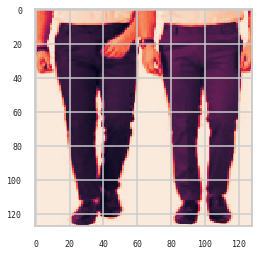

In [41]:
#the class 1 belongs to Shirt category, visualizing the image
im1st = testing.reshape((128,128))
plt.imshow(im1st)
plt.show()


Shape of test image (128, 128)


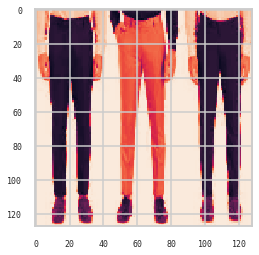

In [42]:
#doing prediction on an unseen image
test4 = cv2.imread(r"C:\Users\saura\saurabh\test_images\men_trouser\img_117.jpeg")
test4=cv2.cvtColor(test4, cv2.COLOR_BGR2GRAY)
test4=cv2.resize(test4,(128,128))
test4 = np.array(test4)
test4 = test4.astype('float32')
test4 =test4/255
print ("Shape of test image",test4.shape)

plt.imshow(test4)
plt.show()


In [43]:
#here the shape is (128,128) so iam defining the no of channel and sample so that it can be processed properly
if channel==1:
    if K.image_data_format()==("channels_first"):
        test_img= np.expand_dims(test4, axis=0)
        test_img= np.expand_dims(test4, axis=0)
        print (test_img.shape)
        print("\nTheano ordering has been used /n")
        print (test_img.shape)
    else:
        test_img= np.expand_dims(test4,axis=2) 
        test_img= np.expand_dims(test_img,axis=0)
        print("Tensorflow ordering has been used")
        print (test_img.shape)
else:
    if K.image_data_format()==("channels_first"):
        test_img=np.rollaxis(test4,2,0)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)
    else:
        test_img= np.expand_dims(test4, axis=0)
        print (test_image.shape)


Tensorflow ordering has been used
(1, 128, 128, 1)


In [44]:
#predicting the class
print(SGD_MO_NEST.predict(test_img))
print("CLASS:", SGD_MO_NEST.predict_classes(test_img))


[[2.8328875e-14 1.0000000e+00]]
CLASS: [1]


#### loading SGD_MOMT_NEST model with 0.01 LR



In [45]:
SGD_MO_NEST=load_model(r"C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.01.h5")

In [46]:
testing = x_test[20:21]
print (testing.shape)
print(SGD_MO.predict(testing))
np.argmax(SGD_MO.predict(testing), axis=-1)


(1, 128, 128, 1)
[[0.00146225 0.9985378 ]]


array([1], dtype=int64)

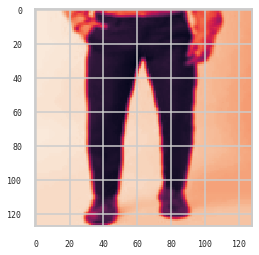

In [47]:
#the class 2 belongs to T_Shirt category, visualizing the image
im21st = testing.reshape((128,128))
plt.imshow(im21st)
plt.show()

Shape of test image (128, 128)


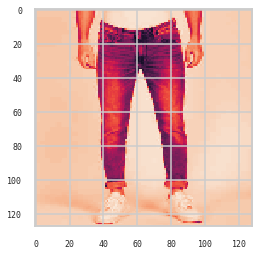

In [48]:
#doing prediction on an unseen image
test5 = cv2.imread(r"C:\Users\saura\saurabh\test_images\men_jeans\img_111.jpeg")
test5=cv2.cvtColor(test5, cv2.COLOR_BGR2GRAY)
test5=cv2.resize(test5,(128,128))
test5 = np.array(test5)
test5 = test5.astype('float32')
test5 =test5/255
print ("Shape of test image",test5.shape)

plt.imshow(test5)
plt.show()


In [49]:
#here the shape is (128,128) so iam defining the no of channel and sample so that it can be processed properly
if channel==1:
    if K.image_data_format()==("channels_first"):
        test_img= np.expand_dims(test5, axis=0)
        test_img= np.expand_dims(test5, axis=0)
        print (test_img.shape)
        print("\nTheano ordering has been used /n")
        print (test_img.shape)
    else:
        test_img= np.expand_dims(test5,axis=2) 
        test_img= np.expand_dims(test_img,axis=0)
        print("Tensorflow ordering has been used")
        print (test_img.shape)
else:
    if K.image_data_format()==("channels_first"):
        test_img=np.rollaxis(test5,2,0)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)
    else:
        test_img= np.expand_dims(test5, axis=0)
        print (test_image.shape)


Tensorflow ordering has been used
(1, 128, 128, 1)


In [50]:
#predicting the class
print(SGD_MO_NEST.predict(test_img))
print("CLASS:", SGD_MO_NEST.predict_classes(test_img))


[[9.999219e-01 7.806761e-05]]
CLASS: [0]


#### loading SGD_MOMT_NEST model with 0.025 LR

In [51]:
SGD_MO_NEST=load_model(r"C:\Users\saura\optimizers\saurabh\assignement4_MCP_sgd_mometum_nestrov0.025.h5")

testing = x_test[7:8]
print (testing.shape)
print(SGD_MO_NEST.predict(testing))
np.argmax(SGD_MO_NEST.predict(testing), axis=-1)

(1, 128, 128, 1)
[[0.42708886 0.5729112 ]]


array([1], dtype=int64)

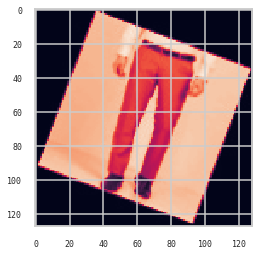

In [52]:
#the class 1 belongs to Shirt category, visualizing the image
im7TH = testing.reshape((128,128))
plt.imshow(im7TH)
plt.show()

Shape of test image (128, 128)


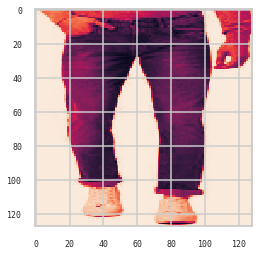

In [53]:
#doing prediction on an unseen image
test6 = cv2.imread(r"C:\Users\saura\saurabh\test_images\men_jeans\img_17.jpeg")
test6=cv2.cvtColor(test6, cv2.COLOR_BGR2GRAY)
test6=cv2.resize(test6,(128,128))
test6 = np.array(test6)
test6 = test6.astype('float32')
test6 =test6/255
print ("Shape of test image",test6.shape)

plt.imshow(test6)
plt.show()


In [54]:
#here the shape is (128,128) so iam defining the no of channel and sample so that it can be processed properly
if channel==1:
    if K.image_data_format()==("channels_first"):
        test_img= np.expand_dims(test6, axis=0)
        test_img= np.expand_dims(test6, axis=0)
        print (test_img.shape)
        print("\nTheano ordering has been used /n")
        print (test_img.shape)
    else:
        test_img= np.expand_dims(test6,axis=2) 
        test_img= np.expand_dims(test_img,axis=0)
        print("Tensorflow ordering has been used")
        print (test_img.shape)
else:
    if K.image_data_format()==("channels_first"):
        test_img=np.rollaxis(test6,2,0)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)
    else:
        test_img= np.expand_dims(test6, axis=0)
        print (test_image.shape)


Tensorflow ordering has been used
(1, 128, 128, 1)


In [55]:
#predicting the class
print(SGD_MO_NEST.predict(test_img))
print("CLASS:", SGD_MO_NEST.predict_classes(test_img))


[[9.995548e-01 4.451178e-04]]
CLASS: [0]


##### LOADING ADAM MODEL WITH 0.001 LR

In [57]:
adam=load_model(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.001.h5")

testing = x_test[3:4]
print (testing.shape)
print(adam.predict(testing))
np.argmax(adam.predict(testing), axis=-1)


(1, 128, 128, 1)
[[0.06825026 0.9317497 ]]


array([1], dtype=int64)

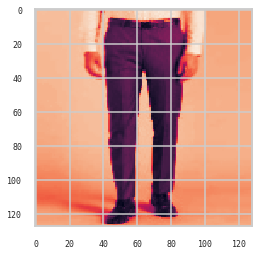

In [58]:
#the class 2 belongs to T_Shirt category, visualizing the image
im3rd = testing.reshape((128,128))
plt.imshow(im3rd)
plt.show()


Shape of test image (128, 128)


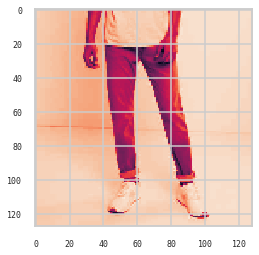

In [59]:
#doing prediction on an unseen image
test10 = cv2.imread(r"C:\Users\saura\saurabh\test_images\men_jeans\img_119.jpeg")
test10=cv2.cvtColor(test10, cv2.COLOR_BGR2GRAY)
test10=cv2.resize(test10,(128,128))
test10 = np.array(test10)
test10 = test10.astype('float32')
test10 =test10/255
print ("Shape of test image",test10.shape)

plt.imshow(test10)
plt.show()


In [60]:
if channel==1:
    if K.image_data_format()==("channels_first"):
        test_img= np.expand_dims(test10, axis=0)
        test_img= np.expand_dims(test10, axis=0)
        print (test_img.shape)
        print("\nTheano ordering has been used /n")
        print (test_img.shape)
    else:
        test_img= np.expand_dims(test10,axis=2) 
        test_img= np.expand_dims(test_img,axis=0)
        print("Tensorflow ordering has been used")
        print (test_img.shape)
else:
    if K.image_data_format()==("channels_first"):
        test_img=np.rollaxis(test10,2,0)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)
    else:
        test_img= np.expand_dims(test10, axis=0)
        print (test_image.shape)

Tensorflow ordering has been used
(1, 128, 128, 1)


In [61]:
#predicting the class
print(adam.predict(test_img))
print("CLASS:", adam.predict_classes(test_img))


[[0.988906   0.01109402]]
CLASS: [0]


###### loading adam with lr 0.01



In [62]:
adam=load_model(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.01.h5")

testing = x_test[111:112]
print (testing.shape)
print(adam.predict(testing))
np.argmax(adam.predict(testing), axis=-1)

(1, 128, 128, 1)
[[1.8361334e-08 1.0000000e+00]]


array([1], dtype=int64)

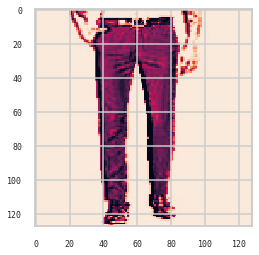

In [63]:
#the class 2 belongs to T_Shirt category, visualizing the image
im111 = testing.reshape((128,128))
plt.imshow(im111)
plt.show()


Shape of test image (128, 128)


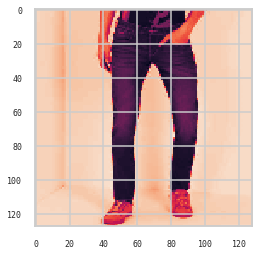

In [64]:
#doing prediction on an unseen image
test11 = cv2.imread(r"C:\Users\saura\saurabh\test_images\men_jeans\img_116.jpeg")
test11=cv2.cvtColor(test11, cv2.COLOR_BGR2GRAY)
test11=cv2.resize(test11,(128,128))
test11 = np.array(test11)
test11 = test11.astype('float32')
test11 =test11/255
print ("Shape of test image",test11.shape)

plt.imshow(test11)
plt.show()


In [65]:
if channel==1:
    if K.image_data_format()==("channels_first"):
        test_img= np.expand_dims(test11, axis=0)
        test_img= np.expand_dims(test11, axis=0)
        print (test_img.shape)
        print("\nTheano ordering has been used /n")
        print (test_img.shape)
    else:
        test_img= np.expand_dims(test11,axis=2) 
        test_img= np.expand_dims(test_img,axis=0)
        print("Tensorflow ordering has been used")
        print (test_img.shape)
else:
    if K.image_data_format()==("channels_first"):
        test_img=np.rollaxis(test11,2,0)  # here roll axis is for bringing the 3rd axis to 1st axis 
        print (img_data.shape)
    else:
        test_img= np.expand_dims(test11, axis=0)
        print (test_image.shape)


Tensorflow ordering has been used
(1, 128, 128, 1)


In [66]:
print(adam.predict(test_img))
print("CLASS:", adam.predict_classes(test_img))

[[1.0000000e+00 1.6340854e-11]]
CLASS: [0]


###### loading adam with lr 0.025

In [67]:
adam=load_model(r"C:\Users\saura\optimizers\saurabh\assignment4_MCP_sgd_ADAM0.025.h5")

testing = x_test[124:125]
print (testing.shape)
print(adam.predict(testing))
np.argmax(adam.predict(testing), axis=-1)


(1, 128, 128, 1)
[[0.61227745 0.38772246]]


array([0], dtype=int64)

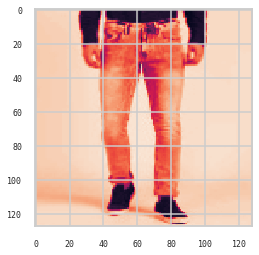

In [68]:
im124 = testing.reshape((128,128))
plt.imshow(im124)
plt.show()